In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import segmentation_models_pytorch as smp


from pathlib import Path
import random

In [2]:
import torch
torch.cuda.set_device(1)

In [3]:
%matplotlib inline
import numpy as np

In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("../../1. Classification of Myopic Maculopathy/Images/")
path_images = path/"TrainingSet"
path_labels = path/"Choroidal"

In [6]:
get_y_fn = lambda x: Path(str(x).replace("TrainingSet","Choroidal"))

In [7]:
codes = ['BG','FG']

In [8]:
monitor_training="dice_multi"
comp_training=np.greater

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=5

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        VerticalFlip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=180),GridDistortion(),CLAHE(),ShiftScaleRotate(),OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [12]:
path_manual_img = path_images
path_manual_lbl = path_labels

../../1. Classification of Myopic Maculopathy/Images/TrainingSet/mmac_task_1_train_0549.png


<Axes: >

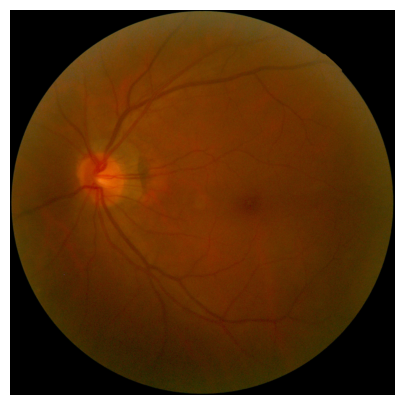

In [13]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [14]:
print(get_y_fn(img_f))

../../1. Classification of Myopic Maculopathy/Images/Choroidal/mmac_task_1_train_0549.png


In [16]:
# mask = PILMask.create(get_y_fn(img_f))
# mask.show(figsize=(5, 5), alpha=1)

In [17]:
bs = 4

In [18]:
codes

['BG', 'FG']

In [26]:
def my_get_image_files(path):
    return [Path(str(x).replace('Choroidal','TrainingSet')) for x in get_image_files(path)]

In [27]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=my_get_image_files,
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((800,800)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

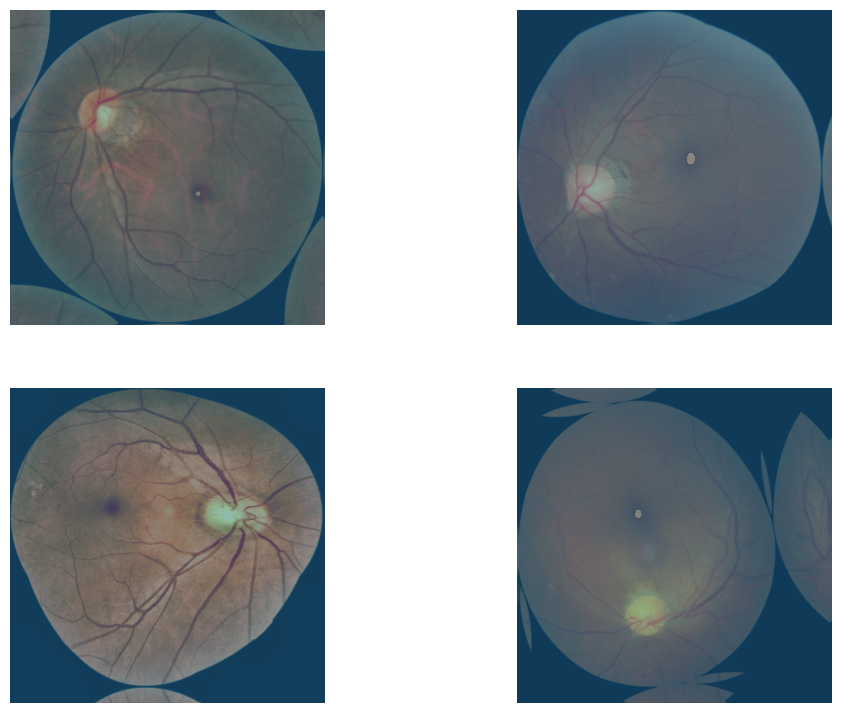

In [28]:
dlsTrain = trainDB.dataloaders(path_labels,bs=bs)

dlsTrain.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [29]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [30]:
learn = Learner(dlsTrain,model,metrics=[DiceMulti()]).to_fp16()

epoch,train_loss,valid_loss,dice_multi,time
0,0.697248,0.647663,0.469385,00:13
1,0.442569,0.440317,0.494738,00:13
2,0.284399,0.214247,0.497736,00:13
3,0.181625,0.125384,0.498824,00:13
4,0.115820,0.073928,0.499643,00:13
5,0.074566,0.043251,0.499685,00:13
6,0.047714,0.028346,0.499685,00:13
7,0.031200,0.020562,0.499685,00:13
8,0.021250,0.015725,0.499685,00:12
9,0.014373,0.009204,0.499685,00:13


Better model found at epoch 0 with dice_multi value: 0.46938469543899963.


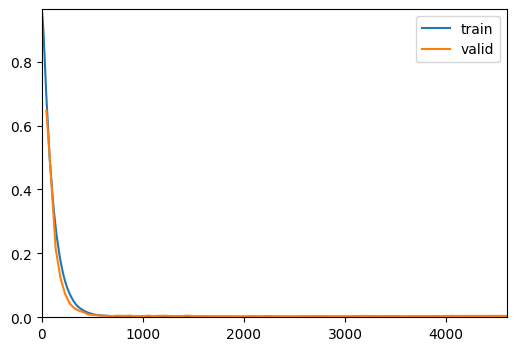

Better model found at epoch 1 with dice_multi value: 0.49473762543537475.
Better model found at epoch 2 with dice_multi value: 0.4977358447109785.
Better model found at epoch 3 with dice_multi value: 0.49882434814820364.
Better model found at epoch 4 with dice_multi value: 0.4996426881132319.
Better model found at epoch 5 with dice_multi value: 0.4996851619330833.
Better model found at epoch 10 with dice_multi value: 0.5325725827537219.
Better model found at epoch 11 with dice_multi value: 0.6394062859533127.
Better model found at epoch 14 with dice_multi value: 0.7551046931149245.
Better model found at epoch 37 with dice_multi value: 0.7908690611806106.
Better model found at epoch 49 with dice_multi value: 0.8015936934903711.
Better model found at epoch 53 with dice_multi value: 0.8017754323955005.


In [31]:
fname="deeplab-resnet50"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(100, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [32]:
path = Path("./")
path_images = path/"1. Images/1. Training Set"
path_labels = path/"2. Groundtruths/1. Training Set"

In [33]:
get_y_fn = lambda x: Path(str(x).replace("1. Images","2. Groundtruths"))

In [34]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((800,800)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

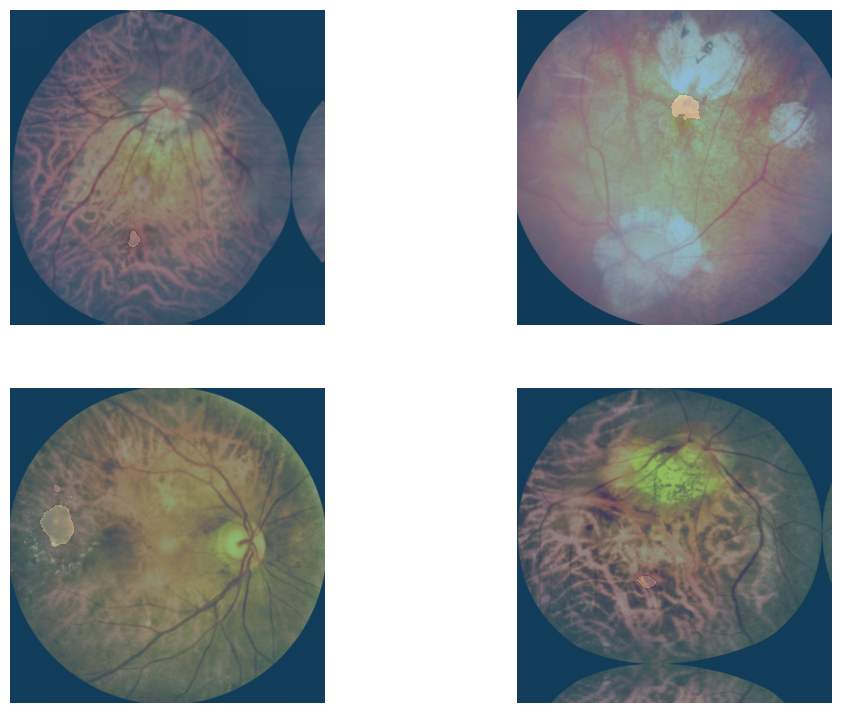

In [35]:
dlsTrain = trainDB.dataloaders(path_images,bs=bs)

dlsTrain.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [36]:
learn.dls = dlsTrain

epoch,train_loss,valid_loss,dice_multi,time
0,0.016188,0.011049,0.703539,00:03
1,0.016973,0.009534,0.756169,00:03
2,0.014746,0.007709,0.811939,00:03
3,0.013752,0.005929,0.846595,00:03
4,0.012414,0.004451,0.865442,00:03
5,0.011674,0.003781,0.858468,00:03
6,0.011036,0.003669,0.831347,00:03
7,0.010311,0.004313,0.739740,00:03
8,0.009643,0.004976,0.667312,00:03
9,0.009339,0.005506,0.660049,00:03


Better model found at epoch 0 with dice_multi value: 0.7035389432320668.


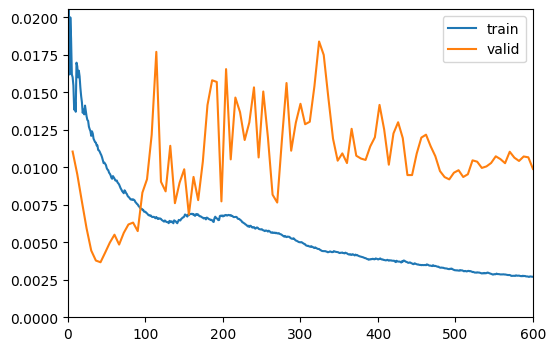

Better model found at epoch 1 with dice_multi value: 0.7561691113992726.
Better model found at epoch 2 with dice_multi value: 0.811939261783472.
Better model found at epoch 3 with dice_multi value: 0.8465952707027317.
Better model found at epoch 4 with dice_multi value: 0.8654422625676992.


In [37]:
fname="deeplab-resnet50-v2"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(100, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [38]:
learn.validate()

(#2) [0.004450714215636253,0.8654422625676992]

In [39]:
aux=learn.model
aux=aux.cpu()

torch.save(aux,'deeplab-choroidal-semi.pth')